# Task 2: Building the baseline model

In [22]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

In [23]:
# List all physical GPUs available to TensorFlow
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPUs are available and recognized by TensorFlow:")
    for gpu in gpus:
        print(" -", gpu)
else:
    print("No GPU found. TensorFlow is running on the CPU.")

import tensorflow as tf


GPUs are available and recognized by TensorFlow:
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [61]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from itertools import product
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import importlib
import seaborn as sns
import sys

import src.preprocessing as preprocessing
import src.models as models

importlib.reload(preprocessing)
importlib.reload(models)

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
# Set up your Image Generators for the training, validation, and test data.
img_height, img_width = 128, 128
channels = 3
batch_size = 32

path_train = "../data/train"
path_val = "../data/val"
path_test = "../data/test"

train_data_gen = preprocessing.get_image_generator(
    path_train, 
    img_height, 
    img_width, 
    batch_size, 
    shuffle=True, 
    preprocess=True)

val_data_gen = preprocessing.get_image_generator(
    path_val, 
    img_height, 
    img_width, 
    batch_size, 
    shuffle=False, 
    preprocess=False)
test_data_gen = preprocessing.get_image_generator(
    path_test, 
    img_height, 
    img_width, 
    batch_size, 
    shuffle=False, 
    preprocess=False)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


## Initial model

In [26]:
# Set up the classification
metrics=['accuracy']

In [27]:
model = models.custom_CNN(
    (img_height, img_width, channels),
    dropout_rate = 0.1,
    filters = 16,
    dense_unit = 512,
    lr =0.001,
    metrics=metrics)

model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_78 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_80 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,413,217 (32.09 MB)

 Trainable params: 8,413,217 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
total_train = train_data_gen.samples
total_val = val_data_gen.samples

print(f"total_train: {total_train}")
print(f"total_val: {total_val}")
print(f"batch_size: {batch_size}")
print(f"steps_per_epoch: {total_train // batch_size}")

total_train: 1600
total_val: 400
batch_size: 32
steps_per_epoch: 50


In [29]:
epochs = 5

history = model.fit(
    train_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.6838 - loss: 0.7304 - val_accuracy: 0.8411 - val_loss: 0.3967
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.8967 - loss: 0.2580 - val_accuracy: 0.8568 - val_loss: 0.3570
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.8933 - loss: 0.2545 - val_accuracy: 0.8698 - val_loss: 0.3284
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.9224 - loss: 0.1889 - val_accuracy: 0.8698 - val_loss: 0.3004
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9155 - loss: 0.2144 - val_accuracy: 0.8620 - val_loss: 0.3224


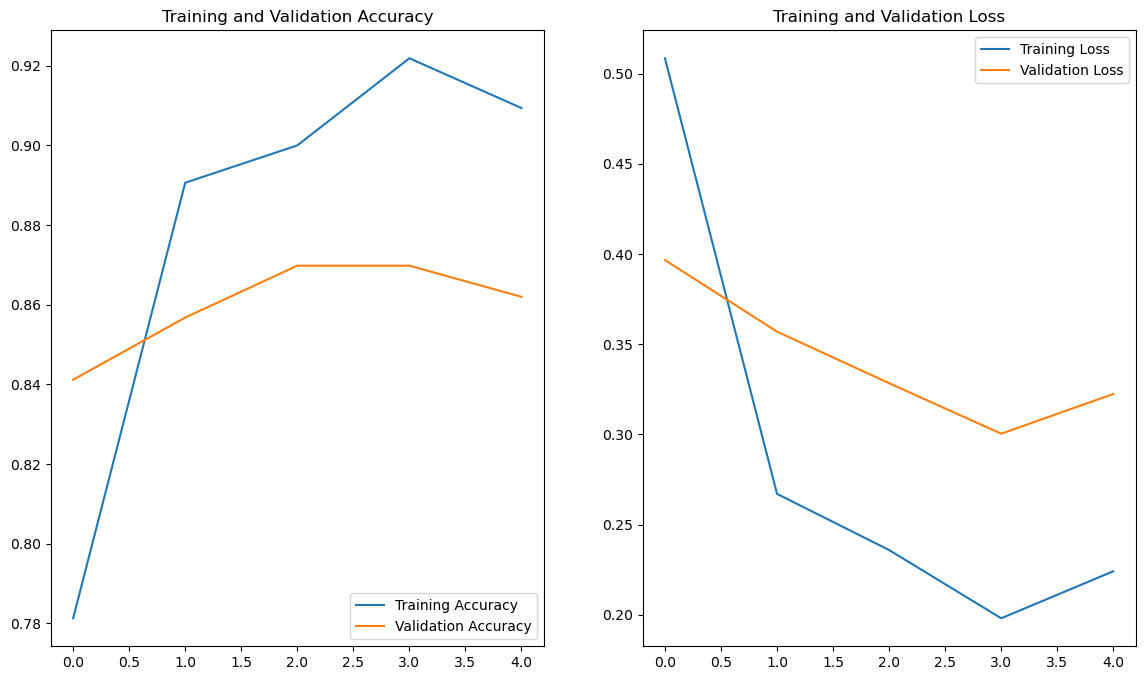

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Hyperparameter tuning

In [31]:
# Hyperparameter options.
dropout_rates = [0.1, 0.2]
first_filters = [16, 8]
learning_rates = [0.001, 0.0005]
dense_units = [512, 256]

# Define EarlyStopping callback.
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

epochs = 5

# Create hyperparameter grid and convert it to a list for progress calculation.
hyperparameter_grid = list(product(dropout_rates, first_filters, learning_rates, dense_units))
total_iterations = len(hyperparameter_grid)
results = []  # List to store results from each run.

print(f"Total iterations: {total_iterations}")

for idx, (dropout_rate, filters, lr, dense_unit) in enumerate(hyperparameter_grid):
    print(f"\nRunning: dropout={dropout_rate}, filters={filters}, lr={lr}, dense_units={dense_unit}")
    
    # Build the model with the current hyperparameters.
    model = models.custom_CNN(
        (img_height, img_width, channels),
        dropout_rate=dropout_rate,
        filters=filters,
        dense_unit=dense_unit,
        lr=lr,
        metrics=metrics
    )
    
    # Set up the optimizer and compile the model.
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    
    # Train the model.
    history = model.fit(
        train_data_gen,
        steps_per_epoch=total_train // batch_size,
        epochs=epochs,
        validation_data=val_data_gen,
        validation_steps=total_val // batch_size,
        callbacks=[early_stop],
        verbose=0  # Reduce training output during tuning.
    )
    
    # Find the best validation accuracy and the corresponding epoch.
    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    final_val_loss = history.history['val_loss'][best_epoch - 1]
    
    # Append hyperparameters and performance metrics to the results.
    results.append({
        'dropout_rate': dropout_rate,
        'first_filters': filters,
        'learning_rate': lr,
        'dense_units': dense_unit,
        'best_val_accuracy': best_val_acc,
        'best_epoch': best_epoch,
        'final_val_loss': final_val_loss
    })
    print(f"Completed: best_val_accuracy={best_val_acc:.4f} at epoch {best_epoch}")

    print(idx + 1, "/", total_iterations, end="\r")  # Print progress.

# Move to a new line after the progress bar.
print("\nHyperparameter tuning complete.")

# Create a DataFrame from the results and save to CSV.
df_results = pd.DataFrame(results)
csv_filename = "../results/hyperparameter_tuning_results.csv"
df_results.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

Total iterations: 16

Running: dropout=0.1, filters=16, lr=0.001, dense_units=512
Completed: best_val_accuracy=0.8516 at epoch 3
Progress: [==--------------------------------------] 6.2%
Running: dropout=0.1, filters=16, lr=0.001, dense_units=256
Completed: best_val_accuracy=0.8568 at epoch 2
Progress: [=====-----------------------------------] 12.5%
Running: dropout=0.1, filters=16, lr=0.0005, dense_units=512
Completed: best_val_accuracy=0.8620 at epoch 4
Progress: [========--------------------------------] 18.8%
Running: dropout=0.1, filters=16, lr=0.0005, dense_units=256
Completed: best_val_accuracy=0.8516 at epoch 4
Progress: [==========------------------------------] 25.0%
Running: dropout=0.1, filters=8, lr=0.001, dense_units=512
Completed: best_val_accuracy=0.8568 at epoch 5
Progress: [============----------------------------] 31.2%
Running: dropout=0.1, filters=8, lr=0.001, dense_units=256
Completed: best_val_accuracy=0.8359 at epoch 5
Progress: [===============----------------

## Final baseline model

In [32]:
results_csv = "../results/hyperparameter_tuning_results.csv"
df_results = pd.read_csv(results_csv)

# Select the best configuration based on highest validation accuracy.
best_config = df_results.sort_values('best_val_accuracy', ascending=False).iloc[0]
best_dropout = best_config['dropout_rate']
best_filters = int(best_config['first_filters'])
best_lr = best_config['learning_rate']
best_dense_units = int(best_config['dense_units'])

print("Best Hyperparameters:")
print(best_config)

best_model = models.custom_CNN(
    (img_height, img_width, channels),
    dropout_rate = best_dropout,
    filters = best_filters,
    dense_unit = best_dense_units,
    lr = best_lr,
    metrics=metrics)

best_model.summary()

Best Hyperparameters:
dropout_rate           0.100000
first_filters          8.000000
learning_rate          0.000500
dense_units          512.000000
best_val_accuracy      0.877604
best_epoch             5.000000
final_val_loss         0.333219
Name: 6, dtype: float64


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_129 (Conv2D)             │ (None, 128, 128, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_129               │ (None, 64, 64, 8)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_130 (Conv2D)             │ (None, 64, 64, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_130               │ (None, 32, 32, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_131 (Conv2D)             │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_131               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_43 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,201,361 (16.03 MB)

 Trainable params: 4,201,361 (16.03 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
path_train_and_val = "../data/train_and_val"

train_and_val_data_gen = preprocessing.get_image_generator(
    path_train_and_val, 
    img_height, 
    img_width, 
    batch_size, 
    shuffle=True, 
    preprocess=True)

Found 2000 images belonging to 2 classes.


In [41]:
total_train_and_val = train_and_val_data_gen.samples

print(f"total_train_and_val: {total_train_and_val}")
print(f"batch_size: {batch_size}")
print(f"steps_per_epoch: {total_train_and_val // batch_size}")

total_train_and_val: 2000
batch_size: 32
steps_per_epoch: 62


In [42]:
epochs_full = 10  # Adjust this as needed.

history_full = best_model.fit(
    train_and_val_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train_and_val // batch_size,
    epochs=epochs_full,
)

Epoch 1/10


/home/luvisser/.conda/envs/ai_project/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8277 - loss: 0.4457
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 167us/step - accuracy: 0.8750 - loss: 0.2761
Epoch 3/10
 2/62 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.8438 - loss: 0.3496

/home/luvisser/.conda/envs/ai_project/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.8523 - loss: 0.3366
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step - accuracy: 0.9062 - loss: 0.2421
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.8887 - loss: 0.2726
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step - accuracy: 0.8750 - loss: 0.2428
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9126 - loss: 0.2293
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 172us/step - accuracy: 0.9688 - loss: 0.1959
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.9063 - loss: 0.2466
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 143us/step - accuracy: 0.9375 - loss: 0.1943


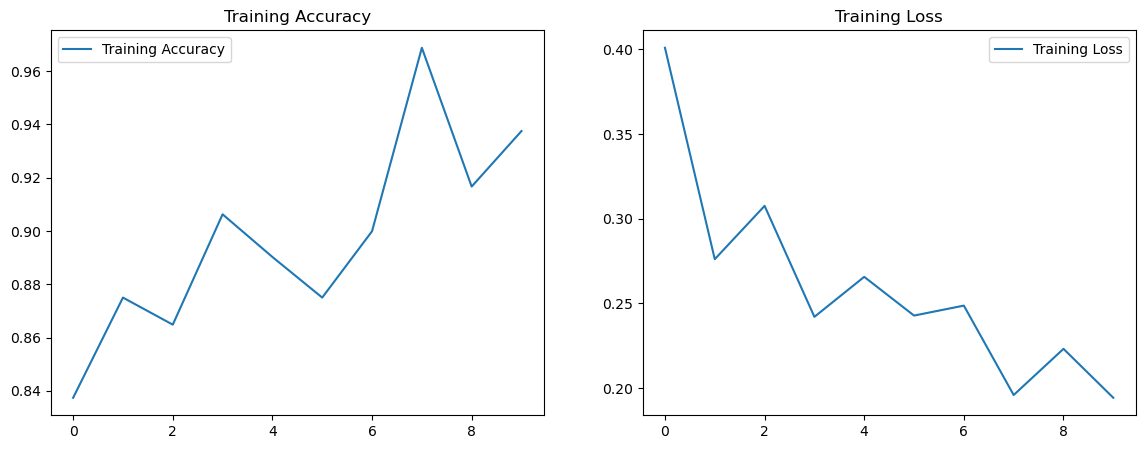

In [43]:
# Retrieve only the training history.
acc = history_full.history['accuracy']
loss = history_full.history['loss']
epochs_range = range(epochs_full)

# Plot only the training curves.
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.title('Training Loss')
plt.legend()

plt.show()

In [45]:
# Define the path where the model will be saved.
model_save_path = "../results/final_baseline.keras"

# Save the retrained model to disk.
best_model.save(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to ../results/final_baseline.keras


In [53]:
# Reload the model from disk.
reloaded_model = load_model(model_save_path)
print("Model loaded from disk.")

# Compute the number of steps per epoch for the test data.
total_test = test_data_gen.samples
steps_test = total_test // batch_size

print(f"total_test: {total_test}")
print(f"steps_test: {steps_test}")

Model loaded from disk.
total_test: 200
steps_test: 6


/home/luvisser/.conda/envs/ai_project/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:

# Evaluate the reloaded model on the test set.
test_loss, test_accuracy = reloaded_model.evaluate(
    test_data_gen, 
    steps=steps_test,
    verbose=1,
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

In [55]:
# Generate predictions on the entire test set.
predictions = reloaded_model.predict(
    test_data_gen, 
    verbose=1
)

# For binary classification, use a threshold of 0.5.
predictions_class = (predictions > 0.5).astype(int).flatten()

# Get ground truth labels from the generator.
true_labels = test_data_gen.classes

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


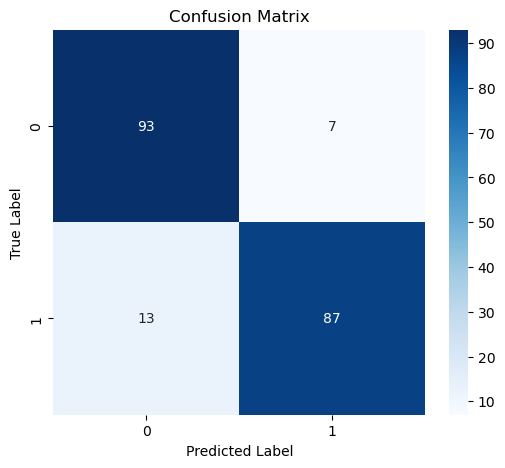

In [59]:
# Compute the confusion matrix.
cm = confusion_matrix(true_labels, predictions_class)

# Plot the confusion matrix.
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Found 200 images belonging to 2 classes.


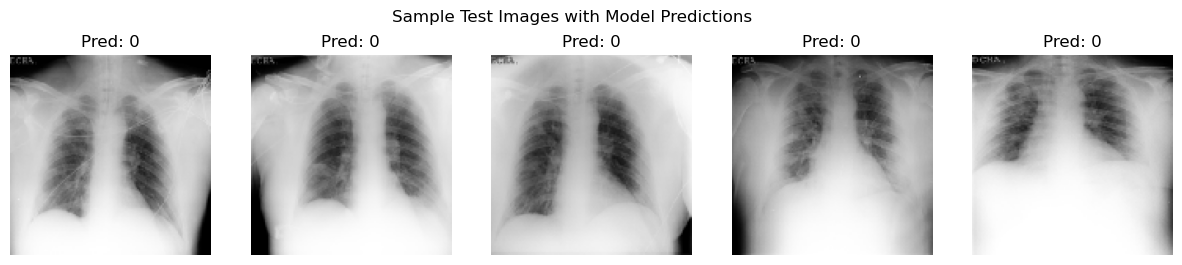

In [63]:
# Create a test data generator WITHOUT normalization (for displaying original images).
test_data_gen_no_norm = preprocessing.get_image_generator(
    path_test, 
    img_height, 
    img_width, 
    batch_size, 
    norm = None, 
    shuffle=False, 
    preprocess=False)

# Get one batch of images and their corresponding labels.
images, labels = next(test_data_gen_no_norm)

# Manually normalize the images for evaluation.
images_norm = images.astype('float32') / 255.0

# Plot a few sample images with the predicted labels.
num_images_to_plot = 5
plt.figure(figsize=(15, 3))
for i in range(num_images_to_plot):
    plt.subplot(1, num_images_to_plot, i+1)
    # Display the original (non-normalized) image.
    plt.imshow(images[i].astype("uint8"))
    plt.title(f"Pred: {predictions_class[i]}")
    plt.axis('off')
plt.suptitle("Sample Test Images with Model Predictions")
plt.show()